In [17]:
from braincoder.models import RegressionGaussianPRF
from braincoder.optimize import ParameterFitter

from neural_priors.utils.data import Subject
import pandas as pd
import numpy as np

from nilearn.maskers import NiftiMasker

In [18]:
subject = 1
bids_folder = '/data/ds-neuralpriors'

In [19]:
sub = Subject(subject, bids_folder)

In [20]:
behavior = sub.get_behavioral_data()
paradigm = behavior[['n', 'range']].rename(columns={'n':'x'})
paradigm['range'] = (paradigm['range']  == 'wide').astype(np.float32)
paradigm = paradigm.astype(np.float32)

In [31]:
paradigm = paradigm.set_index(pd.Index((paradigm.index.get_level_values('run') - 1) % 4 + 1, name='run2'), append=True)

In [35]:
paradigm

x  range
subject session run2 trial_nr run             
01      1       1    1        1    11.0    0.0
                     2        1    23.0    0.0
                     3        1    23.0    0.0
                     4        1    22.0    0.0
                     5        1    21.0    0.0
...                                 ...    ...
        2       4    26       8    12.0    0.0
                     27       8    13.0    0.0
                     28       8    18.0    0.0
                     29       8    14.0    0.0
                     30       8    17.0    0.0

[480 rows x 2 columns]

In [5]:
data = pd.DataFrame(sub.get_single_trial_estimates(None, smoothed=True, roi='NPCr'), index=paradigm.index).astype(np.float32)
# masker = sub.get_volume_mask('NPCr', None, True, return_masker=True)
# data = pd.DataFrame(masker.fit_transform(data), index=paradigm.index).astype(np.float32)

In [6]:
model = RegressionGaussianPRF(paradigm=paradigm, regressors={'mu':'C(range)'})

In [7]:
optimizer = ParameterFitter(model, data, paradigm=paradigm)

modes = np.linspace(1, 50, 100, dtype=np.float32)
delta_modes = np.array([0.0], dtype=np.float32)
sigmas = np.linspace(1, 60, 100, dtype=np.float32)
amplitudes = np.array([1.], dtype=np.float32)
baselines = np.array([0], dtype=np.float32)

grid_parameters = optimizer.fit_grid(modes, delta_modes, sigmas, amplitudes, baselines, use_correlation_cost=True)

Working with chunk size of 1801
Using correlation cost!


  0%|          | 0/6 [00:00<?, ?it/s]

2024-06-13 14:26:48.267181: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [8]:
fixed_pars = list(model.parameter_labels)
fixed_pars.pop(fixed_pars.index(('amplitude_unbounded', 'Intercept')))
fixed_pars.pop(fixed_pars.index(('baseline_unbounded', 'Intercept')))
optimizer.fit(init_pars=grid_parameters, fixed_pars=fixed_pars)

*** Only fitting: ***
 * ('amplitude_unbounded', 'Intercept')
 * ('baseline_unbounded', 'Intercept')
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 771


  0%|          | 0/1000 [00:00<?, ?it/s]

parameter mu_unbounded                 sd_unbounded amplitude_unbounded  \
regressor    Intercept C(range)[T.1.0]    Intercept           Intercept   
source                                                                    
0            10.898990             0.0     1.000000           -1.026951   
1            34.161617             0.0     1.000000           -0.405443   
2            33.666668             0.0     1.000000           -0.555059   
3            14.858586             0.0     1.000000           -1.034672   
4            11.393939             0.0     1.000000           -0.918009   
...                ...             ...          ...                 ...   
766          18.818182             0.0    56.424244            0.452461   
767          10.404040             0.0     1.000000           -1.539774   
768          15.848485             0.0    60.000000            0.479883   
769          30.696970             0.0     1.595960           -1.447796   
770           9.909091             0.0     1.000000           -1.412291   

parameter baseline_unbounded  
regressor          Intercept  
source                        
0                  -0.118072  
1                  -0.509054  
2                  -0.495580  
3                  -0.317576  
4                  -0.113836  
...                      ...  
766                -0.584145  
767                -0.022608  
768                -0.580376  
769                -0.064217  
770                 0.167616  

[771 rows x 5 columns]

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

paradigm = pd.DataFrame({'x':[0,0], 'range':[0,1]}, index=pd.Index(['narrow', 'wide'], name='range'))
pars = model.get_transformed_parameters(paradigm, optimizer.estimated_parameters)

# pars.columns = ['narrow', 'wide']

# pars = pars.join(r2)

# sns.scatterplot(x='narrow', y='wide', data=pars.reset_index(), hue='r2', alpha=0.5, palette='viridis')
# plt.plot([0, 30], [0, 30], 'k--')

In [16]:
paradigm

,x,range
range,,
narrow,0,0
wide,0,1


In [ ]:
pars

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_12962/184896117.py", line 1, in <module>
    pars
NameError: name 'pars' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1012, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/Users/gdehol

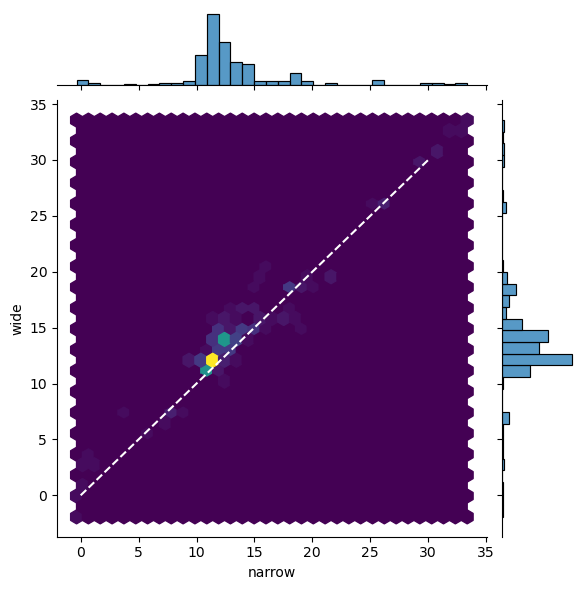

In [ ]:
sns.jointplot(x='narrow', y='wide', data=pars[pars.r2 > 0.02].reset_index(), kind='hex', cmap='viridis')
plt.plot([0, 30], [0, 30], 'w--')

In [ ]:
r2

source
0      0.010755
1      0.011212
2      0.014186
3      0.020537
4      0.020850
         ...   
766    0.009202
767    0.001880
768    0.007961
769    0.003415
770    0.010728
Name: r2, Length: 771, dtype: float32

In [ ]:
pred = model.predict(paradigm, optimizer.estimated_parameters)

from braincoder.utils.stats import get_rsq

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_87999/820444354.py", line 1, in <module>
    pred = model.predict(paradigm, optimizer.estimated_parameters)
  File "/Users/gdehol/git/braincoder/braincoder/models.py", line 74, in predict
    return pd.DataFrame(predictions.numpy(), index=paradigm.index, columns=parameters.index)
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/frame.py", line 782, in __init__
    mgr = ndarray_to_mgr(
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/construction.py", line 336, in ndarray_to_mgr
    _check_values_indices_shape_match(values, index, columns)
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/construction.py", line 420, in _ch

In [ ]:
r2 = get_rsq(data, pred)

<Axes: xlabel="('mu_unbounded', 'C(range)[T.1.0]')", ylabel='Density'>

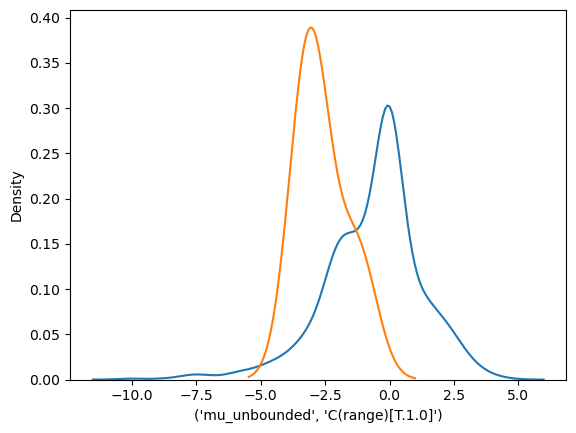

In [ ]:
import seaborn as sns


sns.kdeplot(optimizer.estimated_parameters.iloc[:, 1])
sns.kdeplot(optimizer.estimated_parameters.iloc[np.where((r2 > 0.1))[0], 1])

In [ ]:

import numpy as np
np.asarray(model.design_matrices['mu']).mean(0)

array([1. , 0.5])

In [ ]:
np.array(paradigm)

array([[13.0, 'narrow'],
       [13.0, 'narrow'],
       [18.0, 'narrow'],
       [23.0, 'narrow'],
       [13.0, 'narrow'],
       [20.0, 'narrow'],
       [14.0, 'narrow'],
       [18.0, 'narrow'],
       [15.0, 'narrow'],
       [19.0, 'narrow'],
       [25.0, 'narrow'],
       [19.0, 'narrow'],
       [23.0, 'narrow'],
       [17.0, 'narrow'],
       [20.0, 'narrow'],
       [17.0, 'narrow'],
       [23.0, 'narrow'],
       [22.0, 'narrow'],
       [15.0, 'narrow'],
       [23.0, 'narrow'],
       [10.0, 'narrow'],
       [20.0, 'narrow'],
       [11.0, 'narrow'],
       [17.0, 'narrow'],
       [15.0, 'narrow'],
       [13.0, 'narrow'],
       [22.0, 'narrow'],
       [18.0, 'narrow'],
       [15.0, 'narrow'],
       [21.0, 'narrow'],
       [17.0, 'narrow'],
       [21.0, 'narrow'],
       [18.0, 'narrow'],
       [13.0, 'narrow'],
       [12.0, 'narrow'],
       [22.0, 'narrow'],
       [24.0, 'narrow'],
       [23.0, 'narrow'],
       [21.0, 'narrow'],
       [14.0, 'narrow'],
